# Simple HHL

This notebook demonstrates the simplest variant of HHL from Jack Morgan's code, with sampling to observe the actual output estimate of $x$.

* [Harrow, Hassidm, Lloyd](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502)
* [Lee, Joo, Lee](https://www.nature.com/articles/s41598-019-41324-9)
* [Morgan, Ghysels, Mohamadbagherpoor](https://arxiv.org/abs/2404.10103)
* [Jack Morgan's GitHub repository](https://github.com/jackhmorgan/Enhanced-Hybrid-HHL).

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import ExactReciprocal, HamiltonianGate, PhaseEstimation, StatePreparation
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

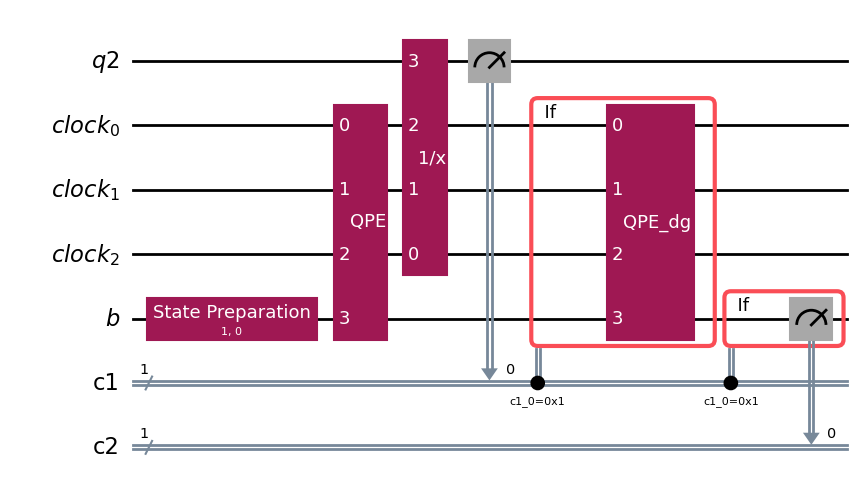

3.3362746496508713


In [ ]:
# Problem setup: Note here that λ is a parameter for the 2x2 problem; the eigenvalues are 1-λ and λ.
λ = 1/4
# λ = 0.97
# LJL problem:
A = np.array([[ 1/2 , λ-1/2],[λ-1/2,  1/2 ]])
b = np.array([[1.], [0.]])
maxλ = 1
# ZMW problem:
# A = np.array([[1, -1/3],[-1/3, 1]])
# b = np.array([[0], [1]])
# maxλ = 4/3

# Parameters of HHL circuit:
π = np.pi
num_clock_qubits = 3
hamiltonian_scale = abs((0.5-2**-num_clock_qubits)/maxλ)
inversion_scale = 2*2**-num_clock_qubits

# Components of HHL circuit:
state_preparation = StatePreparation(Statevector(b))
hamiltonian_simulation = HamiltonianGate(A, -2 * π * hamiltonian_scale)
qpe = PhaseEstimation(num_clock_qubits, hamiltonian_simulation)
eigenvalue_inversion = ExactReciprocal(num_clock_qubits, inversion_scale, neg_vals=True)

# Build circuit:
flag = QuantumRegister(1)
clock_reg = QuantumRegister(num_clock_qubits, "clock")
b_reg = QuantumRegister(qpe.num_qubits - num_clock_qubits, "b")
c_reg = ClassicalRegister(1, "c1")
circuit = QuantumCircuit(flag, clock_reg, b_reg, c_reg)
circuit.append(state_preparation, b_reg)
circuit.append(qpe, clock_reg[:] + b_reg[:])
circuit.append(eigenvalue_inversion, clock_reg[::-1]+[flag[0]])
circuit.measure(0, 0)
with circuit.if_test((0,1)) as passed:
    circuit.append(qpe.inverse(), clock_reg[:] + b_reg[:])
num_b_qubits = int(np.log2(b.size))
c2_reg = ClassicalRegister(1, "c2")
circuit.add_register(c2_reg)
with circuit.if_test((0,1)) as passed:
    circuit.measure(-1, c2_reg[0])

display(circuit.draw(output='mpl'))

backend = AerSimulator()
transpiled_circuit = transpile(circuit, backend)
results = []
for _ in range(100):
    job = backend.run(transpiled_circuit)
    counts = job.result().get_counts()
    # print(counts)
    result = counts['0 1']/counts['1 1']
    results.append(result)

# print(np.average(results))